In [578]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import *
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import collections
import os, time, collections, shutil
%matplotlib inline

helper function is included at the last of this page, including
- showTime(timeInterval)
- dataMatrix(timeInterval,data)
- plotInternet(seriesList, nrows, ncols)
- showNonzero(interaction)
- showDistribution(interaction)
- make_dataset(str_time,end_time) return list of tuple(x,adj) per time interval
- adj_to_sym(interaction)

### load data and preprocess

**Internet data**

In [384]:
names = ['squareId','timeInterval','countryCode','smsIn','smsOut','callIn','callOut','Internet']
dir_ = '../data/raw/milan/sms-call-internet-mi/sms-call-internet-mi-Nov/sms-call-internet-mi-2013-11-03.txt'
data = pd.read_table(dir_,names = names)
data = data.fillna(0)
d = data.groupby(['squareId','timeInterval']).sum()
d = d.drop(['countryCode'],axis = 1)
str_time = min(d.index.get_level_values(1))
end_time = max(d.index.get_level_values(1))

**Interaction data**

In [721]:
interaction =  load_npz('demo/1383464400000.npz')

In [723]:
(1383464400000 - str_time)/600000

52.0

In [719]:
1383343800000 - str_time

-89400000

d = |V| = 10000,k|V| < |E| = 115


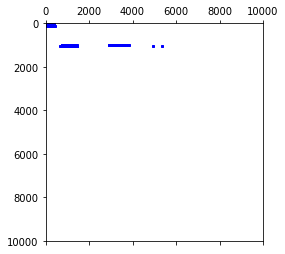

In [718]:
showNonzero(interaction)

variance:  4.2047475e-05
mean:  0.0011537509


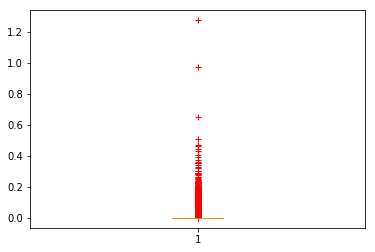

In [43]:
showDistribution(interaction)

### make dataset

In [725]:
(1383467400000 - str_time)/600000

57.0

In [754]:
begin_time = str_time#1383467400000#str_time
period = 600000 * 10
X = make_dataset(begin_time,begin_time+period,d,'../../notebook/demo',64) 
#X = make_dataset(st,st+600000*10,d,64) # X include internet data and the adj graph
XX = list(list(zip(*X))[0])
ADJ = list(list(zip(*X))[1])
XXX = list(zip(XX,ADJ))
for t,i in enumerate(XX):
    tmp = ((i - np.mean(i))/np.std(i))
    XX[t] = tmp
data_y = XX[1:]

making dataset from ../../notebook/demo
finish preparing the dataset....


### gcn package

**buil graph**

In [772]:
def list_of_csr_to_sparse_tensor(adjs):
    # a little bug here
    # I saved the csr matrix in the shape of 10001 * 10001
    # and I convert back to 10000 * 10000 csr sparse tensor
    # sorry for the careless operation...
    indices = []
    data = []
    shape0 = len(adjs)
    shape1,shape2 = adjs[0].shape
    shape1 -= 1
    shape2 -= 1
    for i in range(shape0):
        adj = adjs[i].toarray()
        adj = scipy.sparse.coo_matrix(adj[1:,1:])
        
        row = adj.row
        print('row',(row))
        col = adj.col
        print('col',(col))
        idx = np.ones(row.shape, dtype = np.int32)*i
        indx = list(zip(idx, row, col))
        indices += indx
        data += list(adj.data)
    if indices == []:
        indices = [[0,0,0],]
        data = [0.,]
    #indices = np.transpose(indices)
    #eturn tf.SparseTensor(indices = indices, values = data, dense_shape = (shape0,shape1,shape2))
    return indices,data#,[shape0,shape1,shape2]
    #return tf.SparseTensorValue(indices = indices, values = data, dense_shape = [shape0,shape1,shape2])
    #rint(shape0,shape1,shape2)
    #eturn (np.array(indices),np.array(data),np.array([shape0,shape1,shape2]))

In [687]:
tt = tf.SparseTensor([[0,0,0]],[0],[1,1000,1000])

In [765]:
class st_cgcnn(base_model):
    def __init__(self, F, K, M,num_epochs=20, learning_rate=0.1, decay_rate=0.95, decay_steps=None, momentum=0.9,batch_size=1, eval_frequency=20,
                dir_name=''):
        super().__init__()
        #M denote the number of nodes in the graph
        self.M, self.F, self.K = M,F,K
        self.num_epochs, self.learning_rate = num_epochs, learning_rate
        self.decay_rate, self.decay_steps, self.momentum = decay_rate, decay_steps, momentum
        self.batch_size, self.eval_frequency = batch_size, eval_frequency
        self.dir_name = dir_name
        self.build_graph(M)
    
    def build_graph(self,M):
        self.graph = tf.Graph()
        self.M = M
        with self.graph.as_default():
            #Inputs
            with tf.name_scope('inputs'):
                self.data_x = tf.placeholder(tf.float32, (self.batch_size,M,self.F),'data_x')
                self.data_adj = tf.sparse_placeholder(tf.float32,(self.batch_size, M, M),'data_adj')
                #self.data_adj = tf.SparseTensor([[0,1,1]],np.repeat(2,100000000),[self.batch_size, M, M])
                self.data_y = tf.placeholder(tf.float32,(self.batch_size,M),'data_y')
            #Model
            op_logits = self._inference(self.data_x,self.data_adj)
            p = tf.Print(op_logits,[op_logits],'op_logits')
            self.op_loss,self.op_loss_average = self.loss(p, self.data_y)
            printout_loss = tf.Print(self.op_loss, [self.op_loss],'loss')
            self.op_train = self.training(printout_loss, self.learning_rate, self.decay_steps, self.decay_rate, self.momentum)
            self.op_prediction = self.prediction(op_logits)
            
            #initialize variables, i.e.. weights and biases
            self.op_init = tf.global_variables_initializer()
            
            #summaries for tensorboard and save for model parameters
            self.op_summary = tf.summary.merge_all()
            self.op_saver = tf.train.Saver(max_to_keep = 5)
        self.graph.finalize()
        
    def _inference(self,x,adj):
            #Graph convolutional layer
        #x = tf.expand_dims(x, 2) # N x M x F = 1, N is batch size
            #we use one layer convolution here
        with tf.variable_scope('conv1'):
            with tf.name_scope('filter'):
                x = self.filter_chebyshev(x,adj,1,K = 3) # return N x M x 1
                p = tf.Print(x,[x],'conv1 filter: ')
        return p   
    
    def laplacian(self, adj, normalized = True,sparse = True):
        d = tf.reduce_sum(adj,axis = 0)
        if not normalized:
            D = tf.diag(d)
            L = D - adj
        else:
            d += np.spacing(np.array(0))
            d = 1 / tf.sqrt(d)
            D = tf.diag(d)
            I = tf.eye(tf.size(d))
            L = I - D*adj*D
            #upper bound on the spectrum
            #lmax = linalg.eigsh(L,k = 1, which = 'LM', return_eigenvectors = False)[0]
            #if normalized:
            #    assert lmax <= 2
            #    lmax = 2
        return L
    
    def filter_chebyshev(self, x, adj, Fout = 1, K = 3):
        #Filtering with chebyshev interpolation
        #data : x of size N x M x F
        #N: number of signals, i.e. number of time interval in our model
        #M: number of vertices
        #F: number of features per signal per vertex
        #N,M,Fin = x.get_shape()
        N,M,Fin = x.get_shape().as_list()
        adj = tf.sparse_tensor_to_dense(adj,default_value = 0)
        #for we have different adj matrix at every time Interval, thus we need to filter each signal seperately
        for i in range(N):
            sig = x[i] #1 x M x Fin
            L = adj[i]#self.laplacian(adj[i])
            #Rescale Laplacian 
            I = tf.eye(M)
            lmax = 2 ##temporal
            L /= lmax / 2
            L -= I
            #to Sparse Tensor
            zero = tf.constant(0,dtype = tf.float32)
            where  = tf.not_equal(L,zero)
            indices = tf.where(where)
            values = tf.gather_nd(L, indices)
            L = tf.SparseTensor(indices, values, L.shape)
            
            #Transform to chebyshev basis
            x0 = sig
            x0 = tf.reshape(x0,[M,Fin]) #M x Fin 
            x = tf.expand_dims(x0,0) # 1 x M x Fin
            def concat(x,x_,d = 0):
                #print(tf.shape(x),tf.shape(x_))
                x_ = tf.expand_dims(x_, d)
                return tf.concat([x,x_],axis = d)
            if K > 1:
                x1 = tf.sparse_tensor_dense_matmul(L,x0)
                x = concat(x,x1)
            for k in range(2,K):
                x2 = 2*tf.sparse_tensor_dense_matmul(L,x1) - x0
                x = concat(x, x2)
                x0,x1 = x1, x2
            x = tf.reshape(x, [K,M,Fin]) # K x M x Fin
            if i == 0:
                x_all = tf.expand_dims(x, -1)
            else:
                x_all = concat(x_all,x,-1)
            
        x_all = tf.transpose(x_all, perm = [3,1,2,0]) #N x M x Fin x K    
        x_all = tf.reshape(x_all, [N*M,Fin*K])
                
        #filter: Fin*Fout filter of order K, i.e. one filterbank per feature pair
        W = self._weight_variable([Fin*K,Fout],regularization = False)
        printout = tf.Print(W,[W],'W:')
        x_all = tf.matmul(x_all,printout) # N*M  x Fout
        return tf.reshape(x_all,[N,M])
    
    def loss(self, values, t_values):
        # adds to the inference model the layers required to generate loss
        with tf.name_scope('loss'):
            with tf.name_scope('mse'):
                mse = tf.square(values - t_values)
                mse = tf.reduce_sum(values)
                test = tf.reduce_sum(values)
                #mse = tf.reduce_sum(mse)
                #mse = tf.reduce_mean(mse)
                print(values,t_values,mse)
            loss = mse
            
        #summaries for tensorboard
        tf.summary.scalar('loss/mse',mse)
        with tf.name_scope('averages'):
            #calculate the average loss up to now
            averages = tf.train.ExponentialMovingAverage(0.9)
            op_averages = averages.apply([mse])
            tf.summary.scalar('loss/avg/total', averages.average(loss))
            with tf.control_dependencies([op_averages]):
                loss_average = tf.identity(averages.average(loss), name = 'control')
        return loss, test#loss#_average

    
    def fit(self, train_data, train_y, val_data, val_y):
        #process time
        t_process, t_wall = time.process_time(), time.time()
        sess = tf.Session(graph = self.graph)
        #notice that x is of array form and adj is the list of csr
        train_x,train_adj = train_data
        val_x,val_adj = val_data
        train_x = np.array(train_x)
        train_adj = list(train_adj)
        val_x = np.array(val_x)
        val_adj = list(val_adj)
        train_y = np.array(train_y)
        val_y = np.array(val_y)
        #print(type(train_x),type(train_adj),type(train_y))
        #train_x,train_adj,train_y = list(train_x),list(train_adj),list(train_y)
        #logging the fit information
        shutil.rmtree(self._get_path('summaries'), ignore_errors = True)
        writer = tf.summary.FileWriter(self._get_path('summaries'),self.graph)
        shutil.rmtree(self._get_path('checkpoints'), ignore_errors = True)
        os.makedirs(self._get_path('checkpoints'))
        path = os.path.join(self._get_path('checkpoints'),'model')
        sess.run(self.op_init)
        #Training
        losses = []
        indices = collections.deque()
        num_steps = int(self.num_epochs * train_x.shape[0]/self.batch_size)
        for step in range(1, num_steps+1):
            if len(indices) < self.batch_size:
                indices.extend(np.random.permutation(train_x.shape[0]))
            idx = [indices.popleft() for i in range(self.batch_size)]
            batch_data_x = train_x[idx,...]
            batch_data_adj = [train_adj[i] for i in idx]
            batch_y = train_y[idx]
            if (len(batch_y.shape) == 3):
                batch_y = batch_y.squeeze(-1)
            
            #feed_dict = {self.data_x : batch_data_x, self.data_adj:list_of_csr_to_sparse_tensor(batch_data_adj), self.data_y:batch_y}
            #print(feed_dict)
            pp = list_of_csr_to_sparse_tensor(batch_data_adj)
            feed_dict = {self.data_x : batch_data_x, self.data_y:batch_y,self.data_adj:list_of_csr_to_sparse_tensor(batch_data_adj)}
            learning_rate,loss_average = sess.run([self.op_train,self.op_loss_average],feed_dict)
            
        #periodical evaluation of the model
            epoch = step * self.batch_size / len(train_x)
            print('step {} / {} (epoch {:.2f} / {}):'.format(step, num_steps, epoch, self.num_epochs))
            print('learning_rate = {:.2e}, loss_average = {:.2e}'.format(learning_rate, loss_average))
        
            if step % self.eval_frequency == 0 or step == num_steps:
                print("===========================================================")
                #epoch = step * self.batch_size / len(train_x)
                #print('step {} / {} (epoch {:.2f} / {}):'.format(step, num_steps, epoch, self.num_epochs))
                #print('learning_rate = {:.2e}, loss_average = {:.2e}'.format(learning_rate, loss_average))
                #string, loss = self.evaluate(val_x,val_adj,val_y,sess)
                #losses.append(mse)
                #print(' validation {}'.format(string))
                print(' time: {:.0f}s(wall{:.0f})s'.format(time.process_time() - t_process, time.time() - t_wall))

                #Summaries for tensorboard
                summary = tf.Summary()
                #summary.ParseFromString(sess.run(self.op_summary, feed_dict))
                #summary.value.add(tag='validation/loss', simple_value=loss)
                writer.add_summary(summary, step)

                #save model parameters for evaluation
                self.op_saver.save(sess,path,global_step = step)
        #print('validation mse: smallest = {:.2f}, mean={:.2f}'.format(min(losses),np.mean(mse[-10:])))
        
        writer.close()
        sess.close()
        
        t_step = (time.time() - t_wall) / num_steps
        return losses, t_step
            
            
    def evaluate(self, data_x,adj, data_y, sess = None):
        #return mse and loss
        t_process, t_wall = time.process_time(), time.time()
        predictions, loss = self.predict(data_x, adj, data_y, sess)
        mse = tf.square(prediction - data_y)
        mse = tf.reduce_mean(mse)
        string = 'mse: {:.2f}'.format(mse)
        if sess is None:
            string += '\ntime: {:.0f}s (wall {:.0f}s)'.format(time.process_time()-t_process, time.time()-t_wall)
        return string,mse

In [ ]:
    
    def predict(self, data_x, data_adj, data_y = None, sess = None):
        loss = 0
        size = data_x.shape[0]
        predictions = np.empty(size)
        sess = self._get_session(sess)
        for begin in range(0,size,self.batch_size):
            end = begin + self.batch_size
            end = min([end,size])
            
            batch_data_x = np.zeros((self.batch_size, data_x.shape[1]))
            batch_data_adj = np.zeros((self.batch_size, data_adj.shape[1], data_adj.shape[2]))
            tmp_data_x = data_x[begin:end,:]
            tmp_data_adj = data_adj[begin:end,:]
            #convert sparse matrices
            if type(tmp_data) is not np.ndarray():
                tmp_data = tmp.data.toarray()
            batch_data_x[:end - begin] = tmp_data_x
            batch_data_adj[:end- begin] = tmp_data_adj
            print('predict feed_dict:batch_data_x{},batch_data_adj{}'.format(batch_data_x.shape,batch_data_adj.shape))
            feed_dict = {self.data_x: batch_data_x,self.data_adj:list_of_csr_to_sparse_tensor(batch_data_adj)}
            
            #compute the loss
            if data_y is not None:
                batch_y = np.zeros(self.batch_size)
                batch_y[:end-begin] = data_y[begin:end]
                feed_dict[self.data_y] = batch_y
                batch_pred, batch_loss = sess.run([self.op_prediction, self.op_loss],feed_dict)
                loss += batch_loss
            else:
                batch_pred = sess.run(self.op_prediction, feed_dict)
            predictions[begin:end] = batch_pred[:end-begin]
            
        if labels is not None:
            return predictions, loss * self.batch_size / size
        else:
            return predictions

**train**

In [755]:
n = len(data_y)
n_train = n//2
n_val = n//2
X_train = XXX[:n_train]
X_val = XXX[n_train:n_train+n_val]
X_test = XXX[n_train+n_val:]

y_train = data_y[:n_train]
y_val = data_y[n_train:n_train+n_val]
y_test = data_y[n_train+n_val:]

In [756]:
y_train[3]

array([[-6.95067959e-02],
       [-6.75699032e-02],
       [-6.55081576e-02],
       [-7.51170405e-02],
       [-1.13446175e-01],
       [-6.55081576e-02],
       [-6.55081576e-02],
       [-6.55081576e-02],
       [-6.55081576e-02],
       [-2.38986127e-01],
       [-3.58640775e-01],
       [-3.90086418e-01],
       [-4.31917753e-01],
       [-3.91039991e-01],
       [-3.87131737e-01],
       [-3.79232710e-01],
       [-3.70303970e-01],
       [-3.70303970e-01],
       [-3.70303970e-01],
       [-3.70303970e-01],
       [-3.70303970e-01],
       [-3.70303970e-01],
       [-3.56471529e-01],
       [-2.56439278e-01],
       [-2.53585352e-01],
       [-2.53585352e-01],
       [-2.38144723e-01],
       [-2.13261144e-01],
       [-1.97766710e-01],
       [-1.93222069e-01],
       [-1.92284487e-01],
       [-1.56299396e-01],
       [-1.28330742e-01],
       [-8.47838372e-02],
       [-2.31302133e-01],
       [-2.31302133e-01],
       [-2.31302133e-01],
       [-2.31302133e-01],
       [-2.1

In [728]:
myparams = dict()
myparams['num_epochs'] = 1
myparams['batch_size'] = 1
myparams['eval_frequency'] = 5
#architecture
myparams['F'] = 1
myparams['K'] = 3
myparams['M'] = 64 #output dimensionality of fully connected layers
#Optimization
myparams['learning_rate'] = 1e-5
myparams['decay_rate'] = 0.95
myparams['momentum'] = 0.9
myparams['decay_steps'] = n_train/myparams['batch_size']

In [656]:
X_train

[(array([[-0.51785735],
         [-0.51746651],
         [-0.51705047],
         ...,
         [-0.21716318],
         [-0.35141834],
         [-0.41109992]]),
  <10001x10001 sparse matrix of type '<class 'numpy.float64'>'
  	with 0 stored elements in Compressed Sparse Row format>),
 (array([[-0.51769603],
         [-0.51761428],
         [-0.51752726],
         ...,
         [-0.241952  ],
         [-0.38345954],
         [-0.45086734]]),
  <10001x10001 sparse matrix of type '<class 'numpy.float64'>'
  	with 0 stored elements in Compressed Sparse Row format>),
 (array([[-0.50220301],
         [-0.50166975],
         [-0.50110211],
         ...,
         [-0.15388778],
         [-0.31735318],
         [-0.4746384 ]]),
  <10001x10001 sparse matrix of type '<class 'numpy.float64'>'
  	with 0 stored elements in Compressed Sparse Row format>),
 (array([[-0.50354047],
         [-0.50337874],
         [-0.50320658],
         ...,
         [-0.2256091 ],
         [-0.36157199],
         [-0.4

In [773]:
model =  st_cgcnn(**myparams)
losses, t_step = model.fit(zip(*X_train), y_train, zip(*X_val), y_val)

Tensor("Print:0", shape=(1, 64), dtype=float32) Tensor("inputs/data_y:0", shape=(1, 64), dtype=float32) Tensor("loss/mse/Sum:0", shape=(), dtype=float32)
row [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
col [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
row [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
col [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
step 1 / 5 (epoch 0.20 / 1):
learning_rate = 1

### helper function in this page

In [2]:
#help to return the UTC time with given time interval
import time
def showTime(x):
    tt = time.gmtime(x/1000)
    t = '{}.{} {}:{}'.format(tt.tm_mon,tt.tm_mday,tt.tm_hour,tt.tm_min)
    return t

In [697]:
#form the Internet usage of each timeInterval
#target matrix is naturally the next timeInterval
def dataMatrix(timeInt,data,M):
    #generate the dataMatrix of Internet over the whole grids of a given timeInt
    #data is a pandas dataframe with hierachical index of [grid, time]
    m = int(np.sqrt(M))
    X = np.zeros((M+1,))
    for i in range(1,M+1):
        if timeInt in data.loc[i].index:
            X[i] = data.loc[i].loc[timeInt]['Internet']
    X = X[1:].reshape((m,m))
    return X

In [5]:
#preview the internet stength of several time interval
def plotInternet(seriesList, nrows, ncols):
    assert len(seriesList) == nrows*ncols
    fig, axes = plt.subplots(nrows, ncols, figsize = (15,3*nrows))
    M = 10000
    m = int(np.sqrt(M))
    n = nrows * ncols
    for i,ax in enumerate(axes.flat):
        x = dataMatrix(seriesList[i],d)
        im = ax.imshow(x,vmin = 0)
        #ax.set_title('Interval{}'.format(seriesList[i]))
        ax.set_title(showTime(seriesList[i]))
        
    fig.subplots_adjust(right = 0.8)
    cax = fig.add_axes([0.82,0.16,0.02,0.7])
    fig.colorbar(im, cax = cax)
    plt.show()

In [8]:
#show the pairs that have interaction with each other
def showNonzero(interaction):
    print('d = |V| = {},k|V| < |E| = {}'.format(10000,interaction.nnz))
    plt.spy(interaction,markersize = 2, color = 'blue')

In [42]:
def showDistribution(interaction):
    plt.boxplot(interaction.data,sym = 'r+')
    print('variance: ',np.var(interaction.data))
    print('mean: ',np.mean(interaction.data))

In [752]:
def laplacian1(W, normalized = True,sparse = True):
        
         # Degree matrix.
    d = W.sum(axis=0)

        # Laplacian matrix.
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype))
        d = 1 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D

        # assert np.abs(L - L.T).mean() < 1e-9
    assert type(L) is scipy.sparse.csr.csr_matrix
    return L


In [753]:
def make_dataset(str_time,end_time,data,dir_,nodes = 10000,inter = 600000):
    #return data_all data_all
    print('making dataset from {}'.format(dir_))
    data_x = []
    data_adj = []
    for timeInterval in range(str_time,end_time+1,inter):
        num = inter // 600000
        
        datax = np.zeros((nodes,1))
        adj = scipy.sparse.csr_matrix((nodes+1,nodes+1))

        for i in range(num):
            datax += dataMatrix(timeInterval+i*600000,data,nodes).reshape(nodes,1)
            
            fp_ = '{}/{}.npz'.format(dir_,timeInterval+i*600000)

            if os.path.exists(fp_):
                adj_tmp = load_npz(fp_)
            else:
                adj_tmp = scipy.sparse.csr_matrix((nodes+1,nodes+1))

            adj = adj.toarray()[0:nodes+1][0:nodes+1]
            adj = scipy.sparse.csr_matrix(adj)
            adj += adj_tmp

        adj = adj_to_sym(adj)
        adj = laplacian1(adj)
        data_x.append(datax)
        data_adj.append(adj)

    print('finish preparing the dataset....')
    return list(zip(data_x,data_adj))


In [700]:
def make_dataset(str_time,end_time,data,nodes):
    #return data_all data_all
    data_x = []
    data_adj = []
    for timeInterval in range(str_time,end_time+1,600000):
        test = dataMatrix(timeInterval,data,nodes).reshape(nodes,)
        data_x.append(dataMatrix(timeInterval,data,nodes).reshape(nodes,1))
        fp_ = 'demo/{}.npz'.format(timeInterval)
        if os.path.exists(fp_):
            adj = load_npz(fp_)
            adj = adj.toarray()[0:nodes][0:nodes]
            adj = scipy.sparse.csr_matrix(adj)
        else:
            adj = scipy.sparse.csr_matrix((nodes+1,nodes+1))
        
        data_adj.append(adj)
    return list(zip(data_x,data_adj))

In [64]:
def adj_to_sym(interaction):
    adj = interaction.toarray()
    adj = adj + adj.T
    return scipy.sparse.csr_matrix(adj)

In [734]:
def laplacian(W, normalized=True):
    """Return the Laplacian of the weigth matrix."""

    # Degree matrix.
    d = W.sum(axis=0)

    # Laplacian matrix.
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype))
        d = 1 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D

    # assert np.abs(L - L.T).mean() < 1e-9
    #assert type(L) is scipy.sparse.csr.csr_matrix
    return L

In [737]:
a = np.zeros((10,10))
a = np.matrix(a)
a = scipy.sparse.csr_matrix(a)
l = laplacian(a)

In [738]:
type(l)

scipy.sparse.csr.csr_matrix

In [739]:
l.toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [746]:
g = tf.constant([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])

In [747]:
#f = st_cgcnn(F = 1, K = 1, M = 3)
L = model.laplacian(g)

In [748]:
L

<tf.Tensor 'sub:0' shape=(3, 3) dtype=float32>

In [751]:
sess = model._get_session()
sess.run(L)

ValueError: Fetch argument <tf.Tensor 'sub:0' shape=(3, 3) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("sub:0", shape=(3, 3), dtype=float32) is not an element of this graph.)